In [15]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)

from pydrake.solvers.mosek import MosekSolver


p = AcrobotParams()

m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

# enter the linearized matrices
E = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2, I2 + m2*l1*lc2], \
              [0, 0, I2 + m2*l1*lc2, I2]])

A = np.array([[0, 0, -1, 0], \
              [0, 0, 0, -1], \
              [-m1*gravity*lc1+m2*gravity*(-l1-lc2), -m2*gravity*lc2, b1, 0], \
              [-m2*gravity*lc2, -m2*gravity*lc2, 0, b2]])

B = np.array([[0], [0], [0], [-1]])

A = -A
B = -B

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [16]:
K

array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]])

In [17]:
K_casted = np.insert(K, 1, 0)
K_casted = np.insert(K_casted, 3, 0)
K_casted

array([-278.44223126,    0.        , -112.29125985,    0.        ,
       -119.72457377,  -56.82824017])

In [18]:
A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([2.10360973e+03, 2.05043095e+00, 9.98528759e-01, 7.65896243e-03])

In [19]:
t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")

x = np.hstack([t1, t2, td1, td2])
V_candidate = x.T@E.T@P@E@x
Polynomial(V_candidate)

<Polynomial "80.91247036766552*td2^2 + 325.76452518070187*td1 * td2 + 328.06019370446921*td1^2 + 325.00590715317509*t2 * td2 + 654.32926244338728*t2 * td1 + 327.48490678102974*t2^2 + 754.43992843215551*t1 * td2 + 1519.4572447750918*t1 * td1 + 1515.5320202469929*t1 * t2 + 1760.7194856732497*t1^2">

In [30]:
# finding the bound
negative_infinity = float('-inf')
coeff = 1e-2
positive_infinity = float('inf')

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0, u):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(Vdot.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + Vdot.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)

    prog.AddSosConstraint(Polynomial((x-x_0).dot(x-x_0))*(V - rho) -lambda_*Vdot \
                          + lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
    
#     prog.AddSosConstraint(Vdot + Polynomial((x-x_0).dot(x-x_0)) + lambda_*(V + 362) + \
#                           lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
    
    prog.AddLinearCost(-rho)
    #prog.AddLinearConstraint(rho, 0, positive_infinity)
    
    
        
    solver = MosekSolver()
    result = solver.Solve(prog)

    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)\
, result.GetSolution(rho)

def verify_V_positive_definite(x, V): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)
    
    s_deg = max(V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(x), s_deg)
    
    prog.AddSosConstraint(V + lambda_s*trig + lambda_s2*trig2)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
    print("V assertion solution status: " + str(k))
    
    assert result.is_success()
    
    print('Reached here means result is success')

def problem_solver_implicit(V_degree, G):
    prog = MathematicalProgram()
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")
    
    x = np.hstack([s1, c1, s2, c2, td1, td2])
    x_0 = np.array([0, 1, 0, 1, 0, 0])
    
    xd = prog.NewIndeterminates(6, 'xd')

    u = -G@(x - x_0)
            
    g0 = xd[0] - c1[0]*td1[0]
    g1 = xd[1] + s1[0]*td1[0]
    g2 = xd[2] - c2[0]*td2[0]
    g3 = xd[3] + s2[0]*td2[0]
    g4 = I1*xd[4] + I2*xd[4] + m2*l1**2*xd[4] * 2*m2*l1*lc2*c2[0]*xd[4] + \
            I2*xd[5] + m2*l1*lc2*c2[0]*xd[5] - 2*m2*l1*lc2*s2[0]*td1[0]*td2[0] - \
                m2*l1*lc2*s2[0]*td2[0]**2 - \
                    m1*gravity*lc1*s1[0] + m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))
    g5 = I2*xd[4] + m2*l1*lc2*c2[0]*xd[4] + I2*xd[5] + m2*l1*lc2*s2[0]*td1[0]**2 + \
            m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) - u
        
    g = np.array([g0, g1, g2, g3, g4, g5])
    
    
    V = 80.91247036766552*td2[0]**2 + 325.76452518070187*td1[0] * td2[0] + 328.06019370446921*td1[0]**2 + \
    325.00590715317509*s2[0] * td2[0] + 654.32926244338728*s2[0] * td1[0] + 327.48490678102974*(2-2*c2[0]) + \
    754.43992843215551*s1[0] * td2[0] + 1519.4572447750918*s1[0] * td1[0] + 1515.5320202469929*s1[0] * s2[0] + \
    1760.7194856732497*(2-2*c1[0])
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0, Polynomial(u))
        
        verify_V_positive_definite(x, V)
        print(rho)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(V_degree, K_casted)

Lambda solution status: 1
V assertion solution status: 1
Reached here means result is success
0.0017623894685293298


$ V(x)=(4176.408784909 - 3521.438971346c1_{0} - 654.969813562c2_{0} + 1515.532020247s1_{0} s2_{0} + 1519.457244775s1_{0} \dot{t1}_{0} + 754.439928432s1_{0} \dot{t2}_{0} + 654.329262443s2_{0} \dot{t1}_{0} + 325.005907153s2_{0} \dot{t2}_{0} + 325.764525181\dot{t1}_{0} \dot{t2}_{0} + 328.060193704\dot{t1}_{0}^{2} + 80.912470368\dot{t2}_{0}^{2})$

In [29]:
# finding the bound
negative_infinity = float('-inf')
coeff = 1e-2
positive_infinity = float('inf')

def find_implicit_lambdas(x, xd, V, Vdot, g, x_0, u):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    #rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(Vdot.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + Vdot.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    lambda_s2 = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)    
    trig2 = Polynomial(x[2]**2 + x[3]**2 - 1)
    
    rho = 1e-6
    prog.AddSosConstraint(-Vdot + lambda_*(V - rho) \
                         + lambda_g.dot(g) + lambda_s*trig + lambda_s2*trig2)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)\
, result.GetSolution(rho)

def problem_solver_implicit(V_degree, G):
    prog = MathematicalProgram()
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")
    
    x = np.hstack([s1, c1, s2, c2, td1, td2])
    x_0 = np.array([0, 1, 0, 1, 0, 0])
    
    xd = prog.NewIndeterminates(6, 'xd')

    u = -G@(x - x_0)
            
    g0 = xd[0] - c1[0]*td1[0]
    g1 = xd[1] + s1[0]*td1[0]
    g2 = xd[2] - c2[0]*td2[0]
    g3 = xd[3] + s2[0]*td2[0]
    g4 = I1*xd[4] + I2*xd[4] + m2*l1**2*xd[4] * 2*m2*l1*lc2*c2[0]*xd[4] + \
            I2*xd[5] + m2*l1*lc2*c2[0]*xd[5] - 2*m2*l1*lc2*s2[0]*td1[0]*td2[0] - \
                m2*l1*lc2*s2[0]*td2[0]**2 - \
                    m1*gravity*lc1*s1[0] + m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))
    g5 = I2*xd[4] + m2*l1*lc2*c2[0]*xd[4] + I2*xd[5] + m2*l1*lc2*s2[0]*td1[0]**2 + \
            m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) - u
        
    g = np.array([g0, g1, g2, g3, g4, g5])
    
    
    V = 80.91247036766552*td2[0]**2 + 325.76452518070187*td1[0] * td2[0] + 328.06019370446921*td1[0]**2 + \
    325.00590715317509*s2[0] * td2[0] + 654.32926244338728*s2[0] * td1[0] + 327.48490678102974*(2-2*c2[0]) + \
    754.43992843215551*s1[0] * td2[0] + 1519.4572447750918*s1[0] * td1[0] + 1515.5320202469929*s1[0] * s2[0] + \
    1760.7194856732497*(2-2*c1[0])
    
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    for i in range(1):
        lambda_, lambda_g, lambda_s, rho = find_implicit_lambdas(x, xd, V, Vdot, g_poly, x_0, Polynomial(u))
        
        #verify_V_positive_definite(x, V)
        print(rho)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(V_degree, K_casted)

Lambda solution status: 5


AssertionError: 

In [12]:
list(V.indeterminates())

[Variable('s1(0)', Continuous),
 Variable('c1(0)', Continuous),
 Variable('s2(0)', Continuous),
 Variable('c2(0)', Continuous),
 Variable('\dot{t1}(0)', Continuous),
 Variable('\dot{t2}(0)', Continuous)]

In [13]:
var_list = list(V.indeterminates())
s1 = var_list[0]
c1 = var_list[1]
s2 = var_list[2]
c2 = var_list[3]
td1 = var_list[4]
td2 = var_list[5]

env = {s1:0, c1:1, s2:0, c2:1, td1:0, td2:0}


V.Evaluate(env)


4.547473508864641e-13

In [14]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

def acrobot_balancing_example(use_new, num_itr, plotting, max_seed):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 8
    
    points = []
    points_failed = []
    
    seeds = np.linspace(10000, max_seed, num_itr)
    
    disturbance = np.linspace(0, 0.5, num_itr)
    
    start_time = time.time()
    
    failed_V = []
    success_V = []
    for i in range(num_itr):
        context.SetTime(0.)
        
        np.random.seed(int(seeds[i]))
        #print(np.random.randn(2))
        trial = np.append(UprightState().CopyToVector(), 0) + \
                                0.05 * np.append(np.random.randn(2,), np.zeros(3))
        
        env[s1] = np.sin(trial[0] - np.pi)
        env[c1] = np.cos(trial[0] - np.pi)
        env[s2] = np.sin(trial[1])
        env[c2] = np.cos(trial[1])
        env[td1] = trial[2]
        env[td2] = trial[3]
        
        V_evaluated = V.Evaluate(env)
        
            
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        if plotting: 
            plt.figure(figsize=(5, 4))
            plt.plot(log.sample_times(), log.data().transpose())
            plt.xlabel('t')
            plt.ylabel('y(t)')
        
        # teta = log.data()[0]
        t1_end = log.data()[0][-1]
        t2_end = log.data()[1][-1]
        t1d_end = log.data()[2][-1]
        t2d_end = log.data()[3][-1]
        
        if  t1_end - np.pi < 5*1e-2 and t2_end - 0 < 5e-2 and t1d_end - 0 < 5e-2 and t2d_end - 0 < 5e-2:
            points.append(trial[:-1])
            success_V.append(V_evaluated)
        else: 
            points_failed.append(trial[:-1])
            failed_V.append(V_evaluated)
        
#         avg_angle = np.average(teta[2*int(len(teta)/3):])
# #         print(avg_angle)
#         if  avg_angle - np.pi < 2*1e-2:
#             points.append(trial[:-1])
#             success_V.append(V_evaluated)
#         else: 
#             points_failed.append(trial[:-1])
#             failed_V.append(V_evaluated)
            
        if i%500 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return points, points_failed, failed_V, success_V

num_itr = 10000
plotting = False
max_seed = 30000

points_new, points_failed_new, failed_V_new, \
    success_V_new = acrobot_balancing_example(True, num_itr, plotting, max_seed)
points, points_failed, failed_V, success_V = acrobot_balancing_example(False, num_itr, plotting, max_seed)

Reached 0
Reached 500
Reached 1000
Reached 1500
Reached 2000
Reached 2500
Reached 3000
Reached 3500
Reached 4000
Reached 4500
Reached 5000
Reached 5500
Reached 6000
Reached 6500
Reached 7000
Reached 7500
Reached 8000
Reached 8500
Reached 9000
Reached 9500
Loop ended took 79.97414088249207
Reached 0
Reached 500
Reached 1000
Reached 1500
Reached 2000
Reached 2500
Reached 3000
Reached 3500
Reached 4000
Reached 4500
Reached 5000
Reached 5500
Reached 6000
Reached 6500
Reached 7000
Reached 7500
Reached 8000
Reached 8500
Reached 9000
Reached 9500
Loop ended took 122.74219799041748


In [15]:
points_failed = np.array(points_failed)
points = np.array(points)
points_new = np.array(points_new)
points_failed_new = np.array(points_failed_new)

In [16]:
len(points)

7509

In [17]:
len(points_new)

8734

<IPython.core.display.Javascript object>


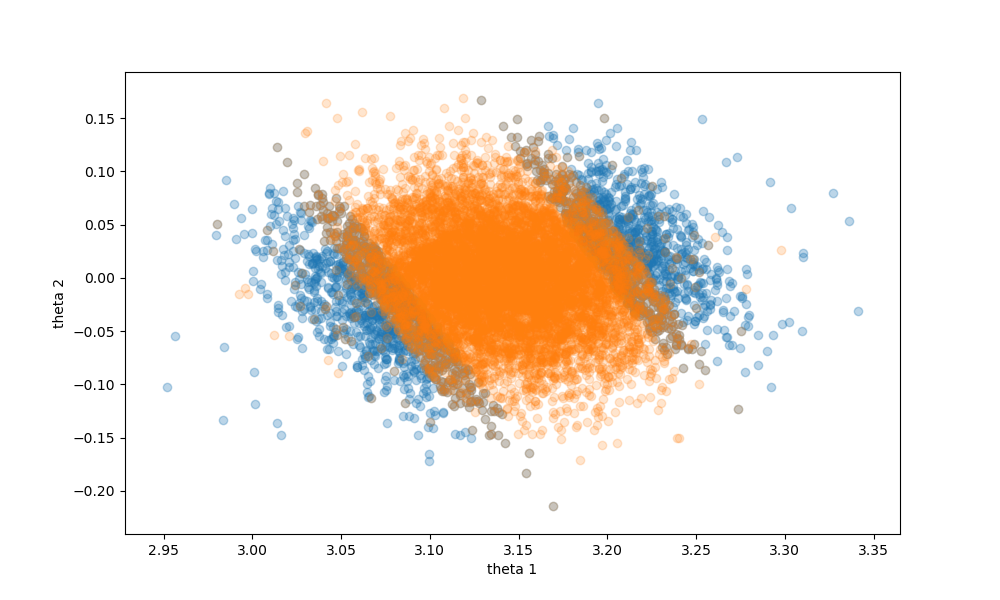

Text(0, 0.5, 'theta 2')

In [18]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

img = ax.scatter(points_failed[:, 0], points_failed[:, 1], alpha = 0.3)
img2 = ax.scatter(points_new[:, 0], points_new[:, 1], alpha=0.2)

ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [60]:
tr1 = np.linspace(np.pi/2, (3*np.pi)/2, 1000)
tr2 = np.linspace(-np.pi/2, np.pi/2, 1000)

TR1, TR2 = np.meshgrid(tr1, tr2)

In [61]:
np.shape(TR1)

(1000, 1000)

In [97]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

def acrobot_balancing_example(use_new, num_itr, plotting):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-3], max_value=[3]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 10
    
    seeds = np.linspace(10000, max_seed, num_itr)
    
    disturbance = np.linspace(0, 0.5, num_itr)
    
    start_time = time.time()
    
    failed_V = []
    success_V = []
    
    tr1 = np.linspace(np.pi/2, (3*np.pi)/2, num_itr)
    tr2 = np.linspace(-np.pi/2, np.pi/2, num_itr)

    TR1, TR2 = np.meshgrid(tr1, tr2)
    
    worked_arr = np.zeros_like(TR1)
    V_eval_arr = np.zeros_like(TR1)
    for i in range(len(TR1)):
        for j in range(len(TR1[i])):
            context.SetTime(0.)

            trial = np.array([TR1[i, j], TR2[i, j], 0, 0, 0])

            env[s1] = np.sin(trial[0] - np.pi)
            env[c1] = np.cos(trial[0] - np.pi)
            env[s2] = np.sin(trial[1])
            env[c2] = np.cos(trial[1])
            env[td1] = trial[2]
            env[td2] = trial[3]

            V_eval_arr[i, j] = V.Evaluate(env)


            context.SetContinuousState(trial)
            simulator.Initialize()
            simulator.AdvanceTo(duration)

            log = logger.FindLog(context)

            if plotting: 
                plt.figure(figsize=(5, 4))
                plt.plot(log.sample_times(), log.data().transpose())
                plt.xlabel('t')
                plt.ylabel('y(t)')
            
            state_end = log.data()[:, -1]

            diff = np.abs(state_end - UprightState().CopyToVector())
            
            tolerance = 5e-2
            
            if np.sum(diff < np.ones(4)*tolerance) == 4:
                worked_arr[i, j] = 1

        if i%1 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return TR1, TR2, worked_arr, V_eval_arr

num_itr = 200
plotting = False

TR1_new, TR2_new, worked_arr_new, \
    V_eval_arr_new = acrobot_balancing_example(True, num_itr, plotting)
print('Starting Other')
TR1, TR2, worked_arr, V_eval_arr = acrobot_balancing_example(False, num_itr, plotting)

Reached 0
Reached 1
Reached 2
Reached 3
Reached 4
Reached 5
Reached 6
Reached 7
Reached 8
Reached 9
Loop ended took 2.5875985622406006
Starting Other
Reached 0
Reached 1
Reached 2
Reached 3
Reached 4
Reached 5
Reached 6
Reached 7
Reached 8
Reached 9
Loop ended took 2.403634786605835


In [98]:
V

<Polynomial "4176.408784908559*1 + 80.91247036766552*\dot{t2}(0)^2 + 325.76452518070187*\dot{t1}(0) * \dot{t2}(0) + 328.06019370446921*\dot{t1}(0)^2 + -654.96981356205947*c2(0) + 325.00590715317509*s2(0) * \dot{t2}(0) + 654.32926244338728*s2(0) * \dot{t1}(0) + -3521.4389713464993*c1(0) + 754.43992843215551*s1(0) * \dot{t2}(0) + 1519.4572447750918*s1(0) * \dot{t1}(0) + 1515.5320202469929*s1(0) * s2(0)">

In [99]:
success_indices_new = np.where(worked_arr_new == 1)

In [100]:
success_indices = np.where(worked_arr == 1)

In [101]:
len(success_indices_new[0])

0

In [85]:
np.save('./100by100TR1.npy', TR1)
np.save('./100by100TR2.npy', TR2)
np.save('./worked_arr.npy', worked_arr)
np.save('./V_eval_arr.npy', V_eval_arr)
np.save('./worked_arr_new.npy', worked_arr_new)
np.save('./V_eval_arr_new.npy', V_eval_arr_new)

In [104]:
TR1 = np.load('./100by100TR1.npy')
TR2 = np.load('./100by100TR2.npy')
worked_arr = np.load('./worked_arr.npy')
V_eval_arr = np.load('./V_eval_arr.npy')
worked_arr_new = np.load('./worked_arr_new.npy')
V_eval_arr_new = np.load('./V_eval_arr_new.npy')
success_indices_new = np.where(worked_arr_new == 1)
success_indices = np.where(worked_arr == 1)

In [105]:
success_indices_new

(array([ 0,  1,  2,  2,  3,  4,  4,  4,  4,  5,  5,  5,  6,  6,  7,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 10, 10, 10, 11,
        11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14,
        14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17,
        17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20,
        20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22,
        22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25,
        25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27,
        27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30,
        30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 34,
        34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36,
        36, 36, 36, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38,
        39, 

In [106]:
TR1[success_indices_new]

array([2.6814604 , 2.84012669, 1.79292914, 3.88732424, 3.76039121,
       2.23719477, 2.33239455, 3.2209258 , 3.76039121, 2.74492691,
       3.72865795, 3.76039121, 3.53825839, 3.72865795, 1.79292914,
       2.55452736, 2.84012669, 3.69692469, 3.72865795, 1.76119588,
       3.09399276, 3.41132536, 3.66519143, 3.69692469, 3.72865795,
       3.66519143, 3.69692469, 2.39586106, 2.74492691, 3.63345817,
       3.66519143, 3.69692469, 4.23639009, 2.39586106, 3.63345817,
       3.66519143, 3.69692469, 2.61799388, 3.63345817, 3.66519143,
       3.69692469, 3.98252402, 4.04599054, 1.76119588, 2.49106084,
       3.44305862, 3.60172491, 3.63345817, 3.66519143, 4.26812335,
       3.60172491, 3.63345817, 3.66519143, 2.30066129, 3.12572602,
       3.56999165, 3.60172491, 3.63345817, 3.66519143, 2.33239455,
       2.55452736, 3.56999165, 3.60172491, 3.63345817, 3.69692469,
       3.85559098, 4.36332313, 2.6814604 , 3.47479187, 3.53825839,
       3.56999165, 3.60172491, 3.63345817, 3.85559098, 3.53825

In [95]:
TR2[success_indices_new] 

array([-1.22173048, -0.52359878, -0.52359878, -0.17453293, -0.17453293,
        0.17453293,  0.17453293,  0.52359878,  0.52359878,  1.22173048])

<IPython.core.display.Javascript object>


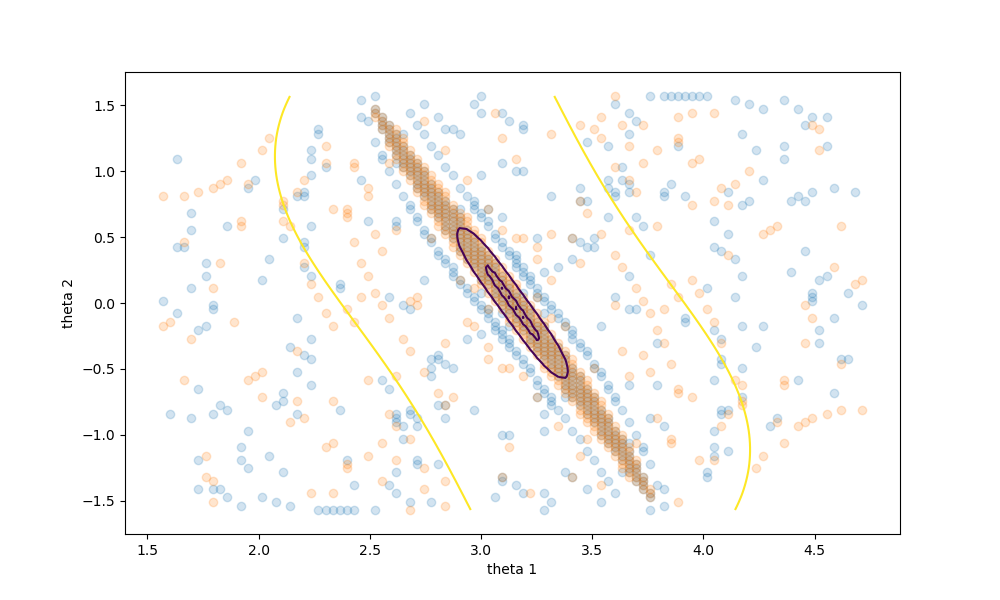

Text(0, 0.5, 'theta 2')

In [109]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
img = ax.scatter(TR1[success_indices], TR2[success_indices], alpha=0.2)
img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)

Vplot = np.zeros_like(TR1)

for i in range(len(TR1)):
    for j in range(len(TR1[i])): 
        env[s1] = np.sin(TR1[i, j] - np.pi)
        env[c1] = np.cos(TR1[i, j] - np.pi)
        env[s2] = np.sin(TR2[i, j])
        env[c2] = np.cos(TR2[i, j])
        Vplot[i, j] = V.Evaluate(env)

ax.contour(TR1,TR2, Vplot, levels=[0.1, 1, 10, 1000])
ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")

In [112]:
# try out the controller
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

M = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*pf.cos(t2), I2 + m2*l1*lc2*pf.cos(t2)], \
              [0, 0, I2 + m2*l1*lc2*pf.cos(t2), I2]])

K2 = B.T@X@M
u_new = -K2@(x - UprightState().CopyToVector())

own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u_new)

In [114]:
K2

array([[-278.4422312581945, -112.29125984628342,
        <Expression "(18.072653232496453 * (1.3300000000000001 + cos(t2)) - 34.705952348380265 * (2.6630000000000003 + 2 * cos(t2)))">,
        <Expression "(24.036628799220285 - 34.705952348380265 * (1.3300000000000001 + cos(t2)))">]],
      dtype=object)

<IPython.core.display.Javascript object>


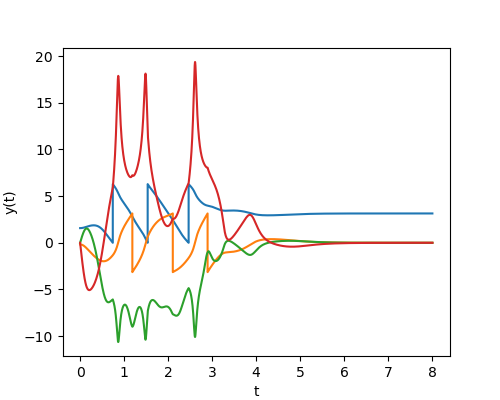

Reached 0
Loop ended took 0.03759598731994629


In [96]:
def acrobot_balancing_example(use_new, num_itr, plotting, max_seed):
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    
    if use_new: 
        controller = builder.AddSystem(own_controller_new)
    else:
        controller = builder.AddSystem(own_controller)
        
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 8
    
    points = []
    points_failed = []
    
    seeds = np.linspace(10000, max_seed, num_itr)
        
    start_time = time.time()
    
    failed_V = []
    success_V = []
    for i in range(num_itr):
        context.SetTime(0.)
        
        np.random.seed(int(seeds[i]))
        trial = np.append(UprightState().CopyToVector(), 0) + \
                                0.05 * np.random.randn(5,)
        
        trial = np.array([ 1.57079633, -0.17453293, 0, 0, 0])
        
        env[s1] = np.sin(trial[0] - np.pi)
        env[c1] = np.cos(trial[0] - np.pi)
        env[s2] = np.sin(trial[1])
        env[c2] = np.cos(trial[1])
        env[td1] = trial[2]
        env[td2] = trial[3]
        
        V_evaluated = V.Evaluate(env)
        
            
        context.SetContinuousState(trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        
        if plotting: 
            plt.figure(figsize=(5, 4))
            plt.plot(log.sample_times(), log.data().transpose())
            plt.xlabel('t')
            plt.ylabel('y(t)')
        
        teta = log.data()[0]
        avg_angle = np.average(teta[2*int(len(teta)/3):])
#         print(avg_angle)
        if  avg_angle - np.pi < 2*1e-2:
            points.append(trial[:-1])
            success_V.append(V_evaluated)
        else: 
            points_failed.append(trial[:-1])
            failed_V.append(V_evaluated)
            
        if i%500 == 0: 
            print("Reached", str(i))
        
    run_time = time.time() - start_time 
    print("Loop ended took", str(run_time))
    return points, points_failed, failed_V, success_V

num_itr = 1
plotting = True
max_seed = 20000

_, __, ____, _____ = acrobot_balancing_example(True, num_itr, plotting, max_seed)

<IPython.core.display.Javascript object>


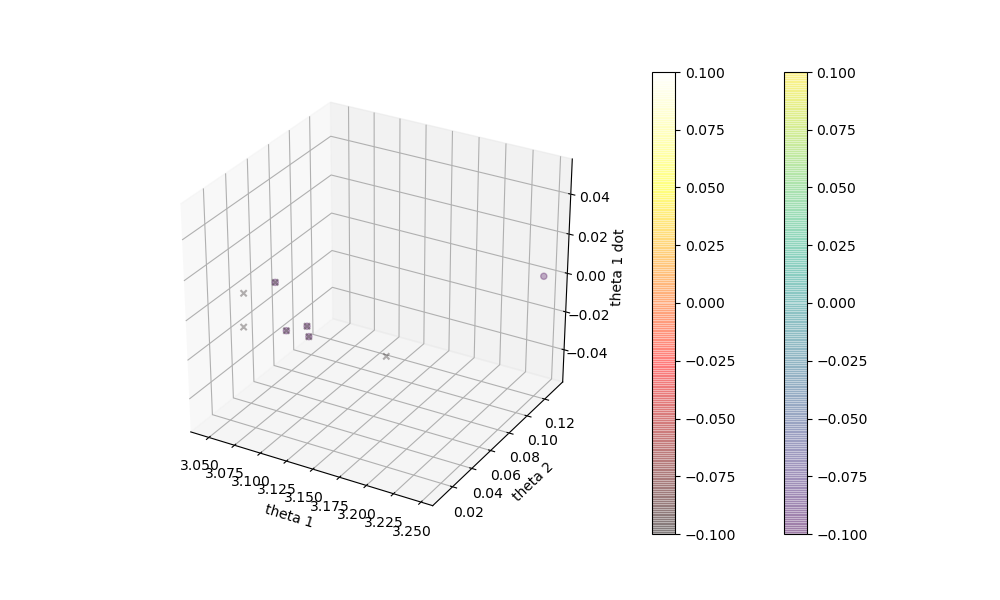

Text(0.5, 0, 'theta 1 dot')

In [44]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(points[:, 0], points[:, 1], points[:, 2], \
                 c = points[:, 3], marker='o', cmap='viridis', alpha=0.3)
fig.colorbar(img)

img2 = ax.scatter(points_new[:, 0], points_new[:, 1], points_new[:, 2], \
                  c = points_new[:, 3], marker='x', cmap = plt.hot(), alpha=0.3)
fig.colorbar(img2)

# img = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c = 'g', marker='o', alpha = 0.1)
# img2 = ax.scatter(points_new[:, 0], points_new[:, 1], points_new[:, 2], \
#                   c = 'b', marker='x', alpha=0.1)


ax.set_xlabel("theta 1")
ax.set_ylabel("theta 2")
ax.set_zlabel("theta 1 dot")

In [103]:
UprightState().CopyToVector() + 0.05 * np.random.randn(4,)

array([ 3.09582565,  0.00313207, -0.08825696,  0.07258637])

New approach to the Acrobot

In [2]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, SolverOptions, CommonSolverOption)

from pydrake.solvers.mosek import MosekSolver

import numpy as np

In [3]:
p = AcrobotParams()

m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

In [4]:
# enter the linearized matrices
E = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2, I2 + m2*l1*lc2], \
              [0, 0, I2 + m2*l1*lc2, I2]])

A = np.array([[0, 0, -1, 0], \
              [0, 0, 0, -1], \
              [-m1*gravity*lc1+m2*gravity*(-l1-lc2), -m2*gravity*lc2, b1, 0], \
              [-m2*gravity*lc2, -m2*gravity*lc2, 0, b2]])

B = np.array([[0], [0], [0], [-1]])

A = -A
B = -B

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([2.10360973e+03, 2.05043095e+00, 9.98528759e-01, 7.65896243e-03])

In [6]:
def find_implicit_V(B, X, S): 
    prog = MathematicalProgram()
    s1 = prog.NewIndeterminates(1, "s1")
    c1 = prog.NewIndeterminates(1, "c1")
    s2 = prog.NewIndeterminates(1, "s2")
    c2 = prog.NewIndeterminates(1, "c2")
    td1 = prog.NewIndeterminates(1, "\dot{t1}")
    td2 = prog.NewIndeterminates(1, "\dot{t2}")

    x = np.hstack([s1, c1, s2, c2, td1, td2])

    M_u_calc = np.array([[1, 0, 0, 0], \
                  [0, 1, 0, 0], \
                  [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
                  [0, 0, I2 + m2*l1*lc2*c2[0], I2]])
    K2 = B.T@X@M_u_calc
    K2 = np.insert(K2, 1, 0)
    K2 = np.insert(K2, 3, 0)
    u = -K2@x

    M = np.array([[1, 0, 0, 0, 0, 0], \
                  [0, 1, 0, 0, 0, 0], \
                  [0, 0, 1, 0, 0, 0], \
                  [0, 0, 0, 1, 0, 0], \
                  [0, 0, 0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c2[0], I2 + m2*l1*lc2*c2[0]], \
                  [0, 0, 0, 0, I2 + m2*l1*lc2*c2[0], I2]])

    Mdot = np.array([[0, 0, 0, 0, 0, 0], \
                  [0, 0, 0, 0, 0, 0], \
                  [0, 0, 0, 0, 0, 0], \
                  [0, 0, 0, 0, 0, 0], \
                  [0, 0, 0, 0, -2*m2*l1*lc2*s2[0]*td2[0], -m2*l1*lc2*s2[0]*td2[0]], \
                  [0, 0, 0, 0, -m2*l1*lc2*s2[0]*td2[0], 0]])

    fx = np.array([[c1[0]*td1[0]], \
                   [- s1[0]*td1[0]], \
                   [c2[0]*td2[0]], \
                   [- s2[0]*td2[0]], \
                   [2*m2*l1*lc2*s2[0]*td1[0]*td2[0] + \
                    m2*l1*lc2*s2[0]*td2[0]**2 + \
                        m1*gravity*lc1*s1[0] - m2*gravity*(-l1*s1[0] + lc2*(-s1[0]*c2[0] - c1[0]*s2[0]))], \
                   [- m2*l1*lc2*s2[0]*td1[0]**2 - \
                m2*gravity*lc2*(-s1[0]*c2[0] - c1[0]*s2[0]) + u]])
    
    V = Polynomial(x.T@M.T@S@M@x)
    Vdot = fx.T@S@M@x + x.T@Mdot.T@S@M@x + x.T@M.T@S@Mdot@x + x.T@M.T@S@fx
    Vdot = Polynomial(Vdot[0])
    

find_implicit_V(B, X, P)    

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 6)

In [8]:
prog = MathematicalProgram()
s1 = prog.NewIndeterminates(1, "s1")
c1 = prog.NewIndeterminates(1, "c1")
s2 = prog.NewIndeterminates(1, "s2")
c2 = prog.NewIndeterminates(1, "c2")
td1 = prog.NewIndeterminates(1, "\dot{t1}")
td2 = prog.NewIndeterminates(1, "\dot{t2}")

z = np.hstack([s1, c1, s2, c2, td1, td2])

t1 = prog.NewIndeterminates(1, "t1")
t2 = prog.NewIndeterminates(1, "t2")
x = np.hstack([t1, t2, td1, td2])

Vx = Polynomial(x.T@E.T@P@E@x)

In [9]:
for m, coeff in Vx.monomial_to_coefficient_map().items():
    print(m)
    print(coeff)

t2(0)^2
327.48490678102974
t1(0) * t2(0)
1515.5320202469929
t1(0)^2
1760.7194856732497
\dot{t2}(0) * t2(0)
325.00590715317509
\dot{t2}(0) * t1(0)
754.43992843215551
\dot{t2}(0)^2
80.91247036766552
\dot{t1}(0) * t2(0)
654.32926244338728
\dot{t1}(0) * t1(0)
1519.4572447750918
\dot{t1}(0) * \dot{t2}(0)
325.76452518070187
\dot{t1}(0)^2
328.06019370446921


In [ ]:
V = 0
for m, coeff in Vx.monomial_to_coefficient_map().items(): 
    monomial = coeff
    for i in range(nx):
        d = m.degree(x[i])
        if i==0:
            if d == 1:
                monomial *= -z[0]
            elif d == 2:
                monomial *= (2-2*z[1])
        elif i==1:
            if d == 1:
                monomial *= z[2]
            elif d == 2:
                monomial *= (2-2*z[3])
        elif i==2 or i==3:
            monomial *= z[i+2]**d
    V += monomial

In [ ]:
    S = prog.NewContinuousVariables(6, 6, "S")

    V = Polynomial(x.T@M.T@S@M@x)

Vdot = fx.T@S@M@x + x.T@Mdot.T@S@M@x + x.T@M.T@S@Mdot@x + x.T@M.T@S@fx
Vdot = Polynomial(Vdot[0])

rho = 0.001

l_deg = math.ceil(V.TotalDegree()/2) * 2
l_deg = 4
s_deg = max(V.TotalDegree()-2, 0)


lambda_, _ = prog.NewSosPolynomial(Variables(x), l_deg)
lambda_trig_1 = prog.NewFreePolynomial(Variables(x), s_deg)
lambda_trig_2 = prog.NewFreePolynomial(Variables(x), s_deg)

trig_1 = Polynomial(x[0]**2 + x[1]**2 - 1)
trig_2 = Polynomial(x[2]**2 + x[3]**2 - 1)

prog.AddSosConstraint(V + lambda_trig_1*trig_1 + lambda_trig_2*trig_2)
prog.AddSosConstraint(-Vdot + lambda_*(V - rho))

# options = SolverOptions()
# options.SetOption(CommonSolverOption.kPrintToConsole, 1)
# prog.SetSolverOptions(options)

solver = MosekSolver()
result = Solve(prog)

assert result.is_success()

In [22]:
K = -Vdot + lambda_*(V - rho)

In [23]:
K.TotalDegree()

7

In [12]:
V.TotalDegree()

5

In [ ]:
prog.AddSosConstraint(-Vdot + lambda_*(V - rho))

In [5]:
prog.AddSosConstraint(V + lambda_trig_1*trig_1 + lambda_trig_2*trig_2)

(array([[Variable('S(0,0)', Continuous), Variable('S(1,0)', Continuous),
         Variable('S(2,0)', Continuous), Variable('S(3,0)', Continuous),
         Variable('S(4,0)', Continuous), Variable('S(5,0)', Continuous),
         Variable('S(6,0)', Continuous), Variable('S(7,0)', Continuous),
         Variable('S(8,0)', Continuous), Variable('S(9,0)', Continuous),
         Variable('S(10,0)', Continuous), Variable('S(11,0)', Continuous),
         Variable('S(12,0)', Continuous), Variable('S(13,0)', Continuous),
         Variable('S(14,0)', Continuous), Variable('S(15,0)', Continuous),
         Variable('S(16,0)', Continuous), Variable('S(17,0)', Continuous),
         Variable('S(18,0)', Continuous), Variable('S(19,0)', Continuous),
         Variable('S(20,0)', Continuous), Variable('S(21,0)', Continuous),
         Variable('S(22,0)', Continuous), Variable('S(23,0)', Continuous),
         Variable('S(24,0)', Continuous)],
        [Variable('S(1,0)', Continuous), Variable('S(1,1)', Continu

In [ ]:
options = SolverOptions()
options.SetOption(CommonSolverOption.kPrintToConsole, 1)
prog.SetSolverOptions(options)


result = Solve(prog)

solver = MosekSolver()

In [ ]:
print('HERE')

result = solver.Solve(prog)

assert result.is_success()

In [133]:
V.TotalDegree()

5

In [120]:
Polynomial(u)

<Polynomial "22.122287824125468*\dot{t2}(0) + 68.385322304516379*\dot{t1}(0) + 34.705952348380265*c2(0) * \dot{t2}(0) + 51.33925146426408*c2(0) * \dot{t1}(0) + 112.29125984628342*s2(0) + 278.44223125819451*s1(0)">

In [121]:
K2

array([-278.4422312581945, 0, -112.29125984628342, 0,
       <Expression "(18.072653232496453 * (1.3300000000000001 + c2(0)) - 34.705952348380265 * (2.6630000000000003 + 2 * c2(0)))">,
       <Expression "(24.036628799220285 - 34.705952348380265 * (1.3300000000000001 + c2(0)))">],
      dtype=object)

In [122]:
B

array([[0],
       [0],
       [0],
       [1]])